In [1]:
from binance.client import Client
import datetime
from pytz import timezone
import os
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from sklearn import preprocessing
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import math

In [2]:
client = Client('', '')

In [6]:
HOUR_FORMAT = '%Y/%m/%d %H:%M:%S'

def to_date(date_str) :
    return datetime.datetime.strptime(date_str, HOUR_FORMAT)

def to_hour_str(timestamp) :
    if isinstance(timestamp, pd.Series) :
        return  pd.DatetimeIndex(pd.to_datetime(timestamp, unit='ms')).tz_localize('UTC').tz_convert('Asia/Seoul').strftime(HOUR_FORMAT)
    elif isinstance(timestamp, datetime.datetime) : 
        return timestamp.strftime(HOUR_FORMAT)
    else :
        return datetime.datetime.fromtimestamp(timestamp/1000).strftime(HOUR_FORMAT)

    
def get_klines_binance_data(symbol, start) :
    TZ_STR = ' KST'
    client = Client('', '')
    klines = []
    if start == '' :
        now_datetime = datetime.datetime.today()
        start = to_hour_str(now_datetime - datetime.timedelta(days=365)) 
        end = to_hour_str(now_datetime - datetime.timedelta(hours=1)) 
        #print(end)
        while True :
            klines_new = client.get_historical_klines(symbol, Client.KLINE_INTERVAL_1HOUR, start + TZ_STR, end + TZ_STR)
            if len(klines_new) == 0:
                break
            klines = klines_new +  klines   
            end = to_hour_str(to_date(start) - datetime.timedelta(hours=1))  
            start = to_hour_str(to_date(start) - datetime.timedelta(days=365))  
    else :    
        klines = client.get_historical_klines(symbol, Client.KLINE_INTERVAL_1HOUR, start + TZ_STR)
        klines = klines[:-1]
    
    df_klines = pd.DataFrame(klines, columns=['open-time', 'open', 'high', 'low', 'close', 'volume', 
                                              'close-time', 'quote-volume', 'trades-cnt', 
                                              'taker-base-volume', 'taker-quote-volume', 'unknown'])   
    df_klines = df_klines.assign(hour = to_hour_str(df_klines['open-time']))
    df_klines = df_klines[['hour', 'open', 'high', 'low', 'close', 'volume']]
    return df_klines
    
def get_klines_data(symbol) :
    file_path = './data/' + symbol + '.csv'
    if os.path.isfile(file_path) :
        data = pd.read_csv(file_path)
        data = data[:-1]
        hours_last = data.tail(1)['hour'].to_string(index=False)
        hour_next = to_hour_str(to_date(hours_last) + datetime.timedelta(hours=1))
        new_data = get_klines_binance_data(symbol, hour_next)
        if len(new_data) > 0 :
            data = data.append(new_data, ignore_index=True)
            data.to_csv(file_path, index=False)
            data = pd.read_csv(file_path)
    else :
        data = get_klines_binance_data(symbol, '')
        data.to_csv(file_path, index=False)
        data = pd.read_csv(file_path)
    return data

# matrix 데이터로 변경한다.
def to_ndarray(cols_data) :
    if isinstance(cols_data, Series):
        return np.reshape(list(cols_data), (-1,1))
    elif isinstance(cols_data, DataFrame):
        return cols_data.as_matrix()

# 컬럼을 스케일링을 시킨다.
def get_scaled_cols(data, column_name) :
    scale_data = to_ndarray(data[column_name])
    scaler = preprocessing.MinMaxScaler()
    return scaler.fit_transform(scale_data), scaler;

# 데이터를 스케일링 시킨다.
def get_scaled_data(data) :
    scaled_data = data.copy()
    scaled_data = scaled_data[['close', 'open', 'high', 'low', 'volume']]
    scaled_data = scaled_data[scaled_data['close']!=0]
    scaled_data['close'], scaler_close = get_scaled_cols(scaled_data, 'close')
    scaled_data['open'], _ = get_scaled_cols(scaled_data, 'open')
    scaled_data['high'], _ = get_scaled_cols(scaled_data, 'high')
    scaled_data['low'], _ = get_scaled_cols(scaled_data, 'low')
    scaled_data['volume'], _ = get_scaled_cols(scaled_data, 'volume')
    return scaled_data, scaler_close;

# RNN을 위한 데이터로 만든다. 
def get_dataXY(data) :
    x = to_ndarray(data)
    y = to_ndarray(data['close'])
    
    dataX = []
    dataY = []
    seq_length = params['seq_length']
    y_len = len(y)
    for i in range(0, y_len - seq_length):
        _x = x[i:i + seq_length]
        _y = y[i + seq_length] # Next close price
        dataX.append(_x)
        dataY.append(_y)
    dataX_last = [x[y_len-seq_length: y_len]]    
    return dataX, dataY, y, dataX_last

# train 및 test 데이터로 나눈다.
def split_train_test(dataX, dataY, data, y) :
    invest_count = params['invest_count']
    seq_length = params['seq_length']
    data_count = len(dataY);
    train_size = int(data_count * params['train_percent'] / 100)
    train_last = data_count-invest_count;
    
    trainX = np.array(dataX[0:train_size])
    testX = np.array(dataX[train_size:train_last])
    investX = np.array(dataX[train_last:data_count])
    
    trainY = np.array(dataY[0:train_size])
    testY = np.array(dataY[train_size:train_last])
    investY = np.array(dataY[train_last:data_count])
    
    trainCloses = np.array( y[seq_length-1:train_size+seq_length-1])
    testCloses = np.array(dataY[train_size-1:train_last-1])
    investCloses = np.array(dataY[train_last-1:data_count-1])
    investRealCloses = np.array(data['close'][train_last-1+seq_length:data_count+seq_length].values)
    #print(investRealCloses)
    return {
        'trainX': trainX, 'trainY': trainY, 'trainCloses': trainCloses,
        'testX': testX, 'testY': testY, 'testCloses' : testCloses,
        'investX': investX,'investY': investY, 'investCloses': investCloses, 'investRealCloses': investRealCloses
    }

# train, test데이터로 만든다.
def get_train_test(data) :
    scaled_data, scaler_close = get_scaled_data(data)
    dataX, dataY, y, dataX_last = get_dataXY(scaled_data)
    return split_train_test(dataX, dataY, data, y), scaler_close, dataX_last

# 텐스플로우 변수관계 그래프롤 그린다.
def draw_graph() :
    seq_length = params['seq_length']
    data_dim = params['data_dim']
    hidden_dims = params['hidden_dims']
    
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
    X_closes = tf.placeholder(tf.float32, [None, 1])
    Y = tf.placeholder(tf.float32, [None, 1])
    output_keep_prob = tf.placeholder(tf.float32)
    
    cells = []
    for n in hidden_dims :
        cell = tf.contrib.rnn.BasicLSTMCell(num_units=n, activation=tf.tanh)
        dropout_cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=output_keep_prob)
        cells.append(dropout_cell)
    stacked_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(cells)
    outputs, _states = tf.nn.dynamic_rnn(stacked_rnn_cell, X, dtype=tf.float32) 
    Y_pred = tf.contrib.layers.fully_connected(
        outputs[:, -1], params['output_dim'], activation_fn=None)  # We use the last cell's output

    # cost/loss
    loss = tf.reduce_sum(tf.square(1-(1+Y_pred-X_closes)/(1+Y-X_closes)))
        
    optimizer = tf.train.AdamOptimizer(params['learning_rate'])
    train = optimizer.minimize(loss)

    # RMSE
    targets = tf.placeholder(tf.float32, [None, 1])
    predictions = tf.placeholder(tf.float32, [None, 1])
    rmse = tf.sqrt(tf.reduce_mean(tf.square(1-(1+predictions-X_closes)/(1+targets-X_closes))))
    
    return {
        'X': X,
        'Y': Y,
        'output_keep_prob': output_keep_prob,
        'train': train,
        'loss' : loss,
        'Y_pred': Y_pred,
        'targets': targets,
        'rmse' : rmse,
        'predictions': predictions,
        'X_closes' : X_closes
    }

def draw_plot(rmse_vals, test_predict, invest_predicts, symbol, data_params) :
    testY = data_params['testY']
    investY = data_params['investY']
    y = np.append(testY,investY)
    predict =  np.append(test_predict, invest_predicts)
    
    mpl.rcParams['axes.unicode_minus'] = False
    font_name = fm.FontProperties(fname=params['kor_font_path'], size=50).get_name()
    plt.rc('font', family=font_name)
    
    plt.figure(1)
    plt.plot(rmse_vals, 'gold')
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Square Error')
    plt.title(symbol)

    plt.figure(2)
    plt.plot(y, 'b')
    plt.plot(predict, 'r')
    plt.xlabel('Time Period')
    plt.ylabel('Stock Price')
    plt.title(symbol)
    plt.show()

def save_learning_image(sess, saver, graph_params, symbol) :
    X = graph_params['X']
    Y = graph_params['Y']
    X_closes = graph_params['X_closes']
    train = graph_params['train']
    Y_pred = graph_params['Y_pred']
    output_keep_prob = graph_params['output_keep_prob']
    
    tf.add_to_collection("X", X)
    tf.add_to_collection("X_closes", X_closes)
    tf.add_to_collection("Y", Y)
    tf.add_to_collection("train", train)
    tf.add_to_collection("Y_pred", Y_pred)
    tf.add_to_collection("output_keep_prob", output_keep_prob)
    saver.save(sess, "./sessions/" + symbol + ".ckpt")
    
# 학습을 시킨다.
def let_training(graph_params, symbol, data_params) :
    X = graph_params['X']
    Y = graph_params['Y']
    output_keep_prob = graph_params['output_keep_prob']
    train = graph_params['train']
    loss = graph_params['loss']
    trainX = data_params['trainX']
    trainY = data_params['trainY']
    testX = data_params['testX']
    testY = data_params['testY']
    trainCloses = data_params['trainCloses']
    testCloses = data_params['testCloses']
    
    Y_pred = graph_params['Y_pred']
    targets = graph_params['targets']
    rmse = graph_params['rmse']
    predictions = graph_params['predictions']
    X_closes = graph_params['X_closes']
    loss_up_count = params['loss_up_count']
    dropout_keep = params['dropout_keep']
    iterations = params['iterations']
    rmse_max = params['rmse_max']
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)

        # Training step
        min_rmse_val = 999999
        less_cnt = 0
        train_count = 0
        rmse_vals = []
        
        for i in range(iterations[1]):
            _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY, X_closes: trainCloses, output_keep_prob: dropout_keep})
            test_predict = sess.run(Y_pred, feed_dict={X: testX, output_keep_prob: 1.0})
            rmse_val = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict, X_closes: testCloses}) 
            rmse_vals.append(rmse_val)
            if rmse_val < min_rmse_val :
                save_learning_image(sess, saver, graph_params, symbol)
                less_cnt = 0
                train_count = i;
                max_test_predict, min_rmse_val, = test_predict, rmse_val
            else :
                less_cnt += 1
            if i > iterations[0] and less_cnt > loss_up_count and rmse_max > min_rmse_val:
                break
        #draw_plot(rmse_vals, max_test_predict, testY, comp_name) 
        return min_rmse_val, train_count, rmse_vals, max_test_predict


# 그래프를 그리고 학습을 시킨다.    
def let_leaning(symbol, data_params):
    graph_params = draw_graph()
    return let_training(graph_params, symbol, data_params)

# 예측 값에 따라 매수 매도를 실행한다.    
def let_invest_money(invest_predict, now_scaled_close, now_close, now_money, now_stock_cnt) :
    seq_length = params['seq_length']
    data_dim = params['data_dim']
    fee_percent = params['fee_percent']
    invest_min_percent = params['invest_min_percent']
    
    ratio = (invest_predict - now_scaled_close) /now_scaled_close * 100
    
    if ratio > invest_min_percent :
        #print(now_money, now_close)
        cnt = math.floor(now_money/now_close)
        if cnt > 0 :
            fee = now_close * fee_percent/100
            now_money -= (now_close + fee) * cnt
            now_stock_cnt += cnt
    elif ratio < -invest_min_percent :
        if now_stock_cnt > 0 :
            now_money += to_money(now_close, now_stock_cnt)
            now_stock_cnt = 0
    return now_money, now_stock_cnt

# 주식매도를 해서 돈으로 바꾼다.
def to_money(now_stock_cnt, now_close) :
    money = 0
    if now_stock_cnt > 0 :
        fee_percent = params['fee_percent'] 
        tax_percent = params['tax_percent']
        
        fee = now_close * fee_percent/100
        tax = now_close * tax_percent/100
        money = (now_close - (fee + tax)) * now_stock_cnt
    return money
    
# 학습 후 모의 주식 거래를 한다.
def let_invest(symbol, train_cnt, dataX_last, data_params):
    invest_count = params['invest_count']
    invest_money = params['invest_money']
    dropout_keep = params['dropout_keep']
    
    investX = data_params['investX']
    investCloses = data_params['investCloses']
    investRealCloses = data_params['investRealCloses']
    investX = data_params['investX']
    investY = data_params['investY']
    testX = data_params['testX']
    testY = data_params['testY']
    testCloses = data_params['testCloses']
    
    now_stock_cnt = 0
    saver = tf.train.Saver()
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        
        saver.restore(sess, "./sessions/" + symbol + ".ckpt") 
        X = tf.get_collection('X')[0]
        X_closes = tf.get_collection('X_closes')[0]
        Y = tf.get_collection('Y')[0]
        train = tf.get_collection('train')[0]
        Y_pred = tf.get_collection('Y_pred')[0]
        output_keep_prob = tf.get_collection('output_keep_prob')[0]
        
        for i in range(int(train_cnt)):
            sess.run(train, feed_dict={X: testX, Y: testY, X_closes: testCloses, 
                                       output_keep_prob: dropout_keep})
        predicts = []
        now_close = 0
        for i in range(invest_count) :
            np.array([1, 2, 3], ndmin=2)
            invest_predicts = sess.run(Y_pred, feed_dict={X: investX[i:i+1], output_keep_prob: 1.0})
            predicts.append(invest_predicts[0])
            
            invest_predict = invest_predicts[0][0];
            now_scaled_close = investCloses[0][0]
            now_close = investRealCloses[i]
            #print(invest_predict, now_scaled_close, now_close)
            invest_money, now_stock_cnt = let_invest_money(invest_predict, now_scaled_close, now_close,
                                                           invest_money, now_stock_cnt)
            for i in range(int(train_cnt/5)):
                sess.run(train, feed_dict={X: investX[i:i+1], Y: investY[i:i+1], X_closes: investCloses[i:i+1], 
                                           output_keep_prob: dropout_keep})
            #break
        invest_money += to_money(now_stock_cnt, now_close)
        graph_params = {'X':X, 'X_closes':X_closes, 'Y':Y, 'train':train, 
                        'Y_pred':Y_pred, 'output_keep_prob':output_keep_prob}
        save_learning_image(sess, saver, graph_params, symbol)
        saver.save(sess, "./sessions/" + symbol + ".ckpt")
        
        last_predict = sess.run(Y_pred, feed_dict={X: dataX_last, output_keep_prob: 1.0})
    #print(now_money)
    return invest_money, last_predict, predicts

# 실제 가격을 가져온다.
def get_real_money(data_params, scaler_close, last_predict) :
    investRealCloses = data_params['investRealCloses'];
    predict_money = scaler_close.inverse_transform(last_predict)
    last_close_money = investRealCloses[len(investRealCloses)-1]
    last_pred_money = predict_money[0][0]
    return last_close_money, last_pred_money

# 다음날 종가를 예측한다.
def predict_next_close(symbol) :
    data = get_klines_data(symbol)
    data_params, scaler_close, dataX_last = get_train_test(data)
    rmse_val, train_cnt, rmse_vals, test_predict  = let_leaning(symbol, data_params)
    last_money, last_predict, invest_predicts = let_invest(symbol, train_cnt, dataX_last, data_params)
    draw_plot(rmse_vals, test_predict, invest_predicts, symbol, data_params)
    last_close_money, last_pred_money = get_real_money(data_params, scaler_close, last_predict)
    print("RMSE:", rmse_val)
    print("train_cnt:", train_cnt)
    if params['invest_count'] > 0 :
        print(str(params['invest_count']) + "회 모의투자 결과:", "{:,.0f}".format(last_money))
    last_date = data.tail(1)['hour'].to_string(index=False)
    
    #print("마지막 종가(" + last_date + "):", "{:,.0f}".format(last_close_money))
    print("마지막 종가(" + last_date + "):", last_close_money)
    last_pred_ratio = (last_pred_money-last_close_money)/last_close_money * 100
    #last_pred_ratio = "(" + "{:.2f}".format(last_pred_ratio) + "%)"
    last_pred_ratio = "(" + last_pred_ratio + "%)"
    #print("예측 종가:", "{:,.0f}".format( last_pred_money ), last_pred_ratio)
    print("예측 종가:", last_pred_money , last_pred_ratio)
    print()

# 다음날 종가를 예측한다.
def predict_invest(symbol) :
    data = get_klines_data(symbol)
    data_params, scaler_close, dataX_last = get_train_test(data)
    rmse_val, train_cnt, rmse_vals, test_predict  = let_leaning(symbol, data_params)
    last_money, last_predict, invest_predicts = let_invest(symbol, train_cnt, dataX_last, data_params)
    draw_plot(rmse_vals, test_predict, invest_predicts, symbol, data_params)
    last_close_money, last_pred_money = get_real_money(data_params, scaler_close, last_predict)
    print("RMSE:", rmse_val)
    print("train_cnt:", train_cnt)
    if params['invest_count'] > 0 :
        print(str(params['invest_count']) + "회 모의투자 결과:", "{:,.0f}".format(last_money))
    print()    

In [4]:
params = {
    'seq_length' : 24, # 시퀀스 갯수
    'data_dim' : 5,    # 입력 데이터 갯수
    'hidden_dims' : [128, 96, 64],  # 히든 레이어 갯수 
    'dropout_keep' : 0.8, # dropout 
    'output_dim' : 1,  # 출력 데이터 갯수
    'learning_rate' : 0.0001, 
    'iterations' : [40, 200],  # 최소, 최대 훈련 반복횟수
    'rmse_max' : 0.045,
    'train_percent' : 80.0, # 훈련 데이터 퍼센트
    'loss_up_count' : 36, # early stopping
    'invest_count' : 24*7,  # 투자 횟수
    'invest_money' : 100000, # 각 주식에 모의투자할 금액
    'fee_percent' : 0.05, # 투자시 발생하는 수수료
    'tax_percent' : 0.0,   # 매도시 발생하는 세금
    'invest_min_percent' : 0.1, # 투자를 하는 최소 간격 퍼센트 
    'kor_font_path' : 'C:\\WINDOWS\\Fonts\\H2GTRM.TTF'
}

INFO:tensorflow:Restoring parameters from ./sessions/ETHUSDT.ckpt


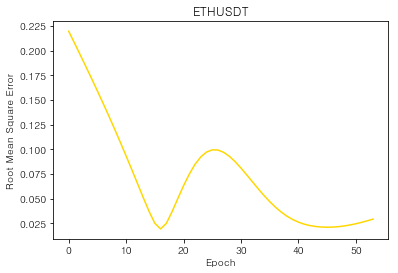

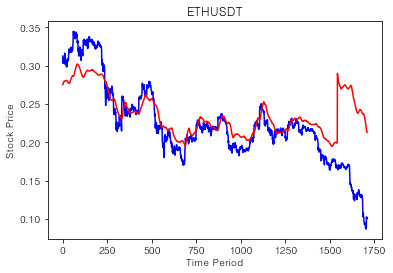

RMSE: 0.019471139
train_cnt: 16
168회 모의투자 결과: 80,146

INFO:tensorflow:Restoring parameters from ./sessions/BTCUSDT.ckpt


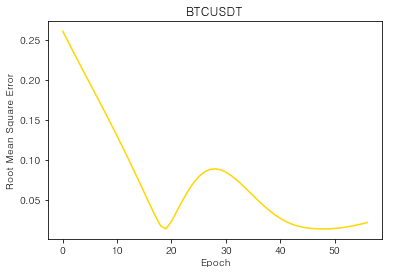

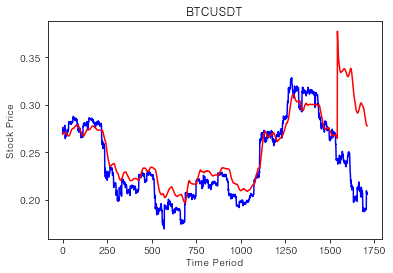

RMSE: 0.013165627
train_cnt: 19
168회 모의투자 결과: 91,763

INFO:tensorflow:Restoring parameters from ./sessions/EOSUSDT.ckpt


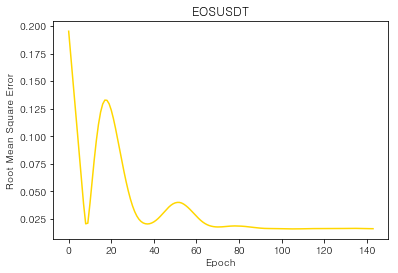

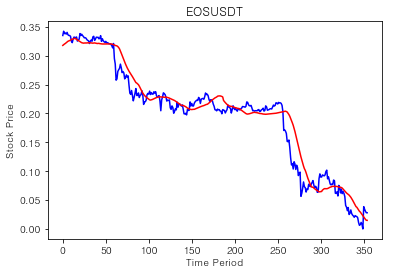

RMSE: 0.016059054
train_cnt: 106
168회 모의투자 결과: 100,132

INFO:tensorflow:Restoring parameters from ./sessions/BCCUSDT.ckpt


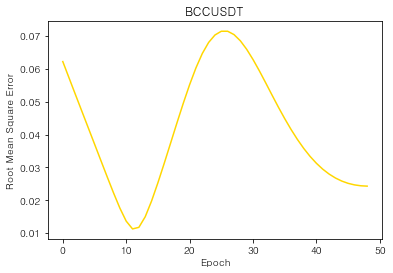

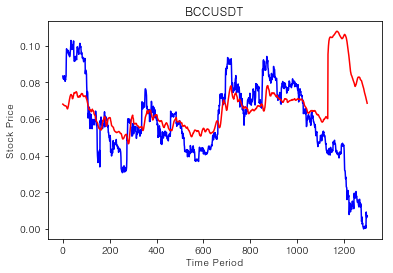

RMSE: 0.011290756
train_cnt: 11
168회 모의투자 결과: 82,470

INFO:tensorflow:Restoring parameters from ./sessions/ADAUSDT.ckpt


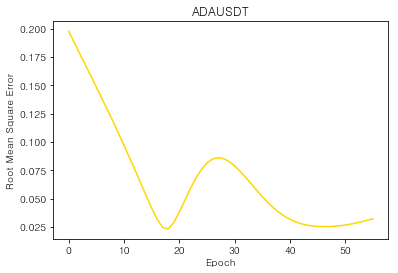

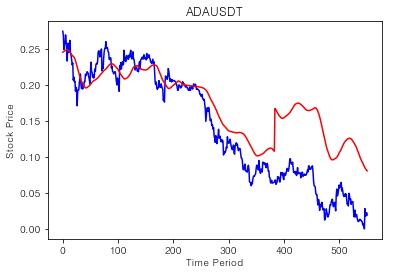

RMSE: 0.023183998
train_cnt: 18
168회 모의투자 결과: 90,565

INFO:tensorflow:Restoring parameters from ./sessions/BNBUSDT.ckpt


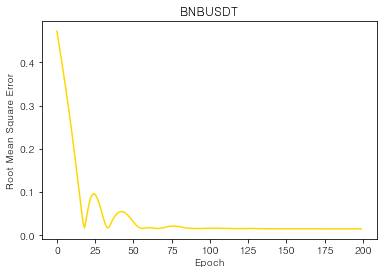

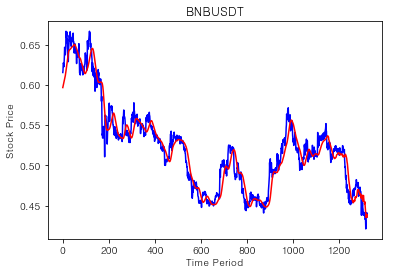

RMSE: 0.014970307
train_cnt: 194
168회 모의투자 결과: 99,960

INFO:tensorflow:Restoring parameters from ./sessions/IOTAUSDT.ckpt


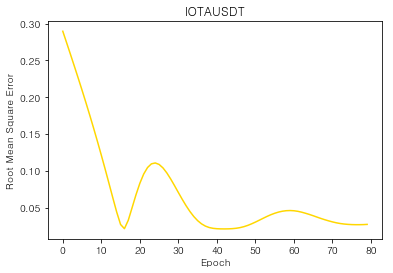

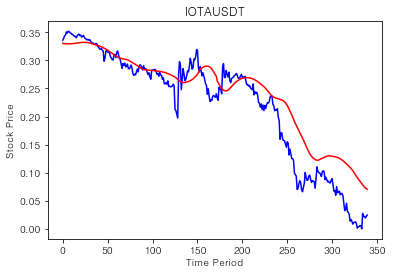

RMSE: 0.021046532
train_cnt: 42
168회 모의투자 결과: 97,529



In [7]:
symbols = ["ETHUSDT","BTCUSDT", "EOSUSDT", "BCCUSDT", "ADAUSDT", "BNBUSDT", "IOTAUSDT"]
for symbol in symbols :
    predict_invest(symbol)